# Testing Notebook

Note, this notebook is based on crutchfield_perry_implementation_convolution.ipynb from https://github.com/UCSD-E4E/pyAqua3dDev/tree/main

In [251]:
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
from scipy.optimize import minimize, least_squares
from typing import Tuple
import torch
import torch.nn.functional as func

In [252]:
#name = "T_S04856"
# name = "T_S04910"
# name = "T_S04911"
# name = "T_S04912"
name = "T_S04923"

png_file = Path(f"data/{name}.png")
tif_file = Path(f"data/depth{name}.tif")


#png_file = Path(f"../../data/seathru/D3/D3/linearPNG/{name}.png")
#tif_file = Path(f"../../data/seathru/D3/D3/depth/depth{name}.tif")

In [253]:
clusters = 10

In [254]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

In [255]:
def uint8_2_double(array: np.ndarray):
    return array.astype(np.float64) / 255.0

def double_2_uint8(array: np.ndarray):
    return (array * 255).astype(np.uint8)

In [256]:
def imshow(img: np.ndarray, color_channel="rgb"):


    if img.dtype == np.float64 and len(img.shape) == 3:
        img = double_2_uint8(img)

    if color_channel == "bgr":
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    elif color_channel == "hsv":
        img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)

    plt.imshow(img)

    if len(img.shape) == 2:
        plt.colorbar()

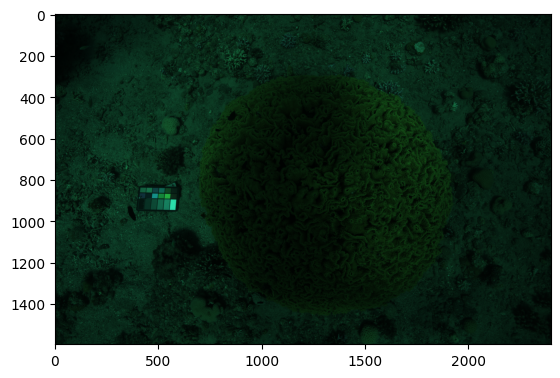

In [257]:
png = uint8_2_double(cv2.imread(png_file))
height, width, _ = png.shape

imshow(png, color_channel="bgr")

In [258]:
png.dtype

dtype('float64')

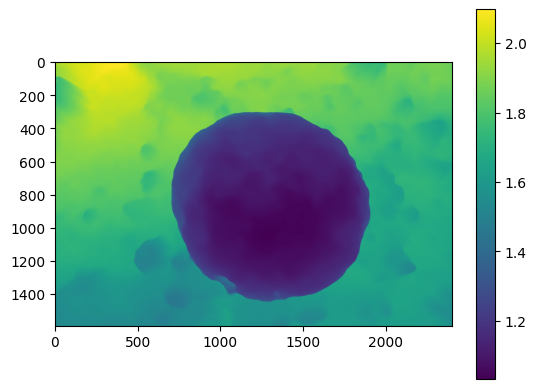

In [259]:
tif_image = Image.open(tif_file)
tif = np.array(tif_image)
tif = cv2.resize(tif, (width, height),  interpolation = cv2.INTER_NEAREST)

imshow(tif)

In [260]:
png.shape, tif.shape

((1596, 2400, 3), (1596, 2400))

In [261]:
tif.min(), tif.max()

(np.float32(1.0321687), np.float32(2.0977757))

In [262]:
tif_flat = tif.flatten()

tif_flat.shape

(3830400,)

## Backscatter Estimation

In [263]:
# kmeans = KMeans(n_clusters=clusters, random_state=0, n_init="auto").fit(tif_flat[tif_flat != 0].reshape(-1, 1))
# labels = np.zeros(tif_flat.shape, dtype=np.uint8)
# labels[tif_flat != 0] = kmeans.labels_
# labels[tif_flat == 0] = 255 # Use 255 to represent nan
# means = np.array(kmeans.cluster_centers_).flatten()
# means_args = np.argsort(means)

# labels_new = np.zeros_like(labels)
# labels_new[labels == 255] = clusters + 1

# for current_label in range(clusters):
#     new_label = np.nonzero(means_args == current_label)[0]
#     labels_new[labels == current_label] = new_label

# labels = labels_new.reshape((height, width))
# imshow(labels)

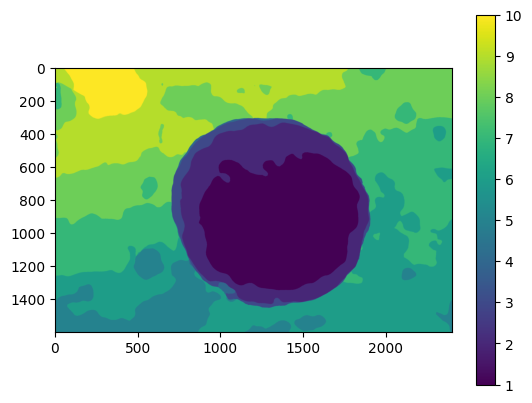

In [264]:
_, edges = np.histogram(tif_flat, clusters)

labels = np.zeros(tif.shape, dtype=np.uint8)
for i in range(clusters + 1):
    labels[np.logical_and(tif <= edges[i], labels == 0)] = i

imshow(labels)

In [265]:
np.unique_counts(labels)

UniqueCountsResult(values=array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8), counts=array([624129, 367726,  80555,  11589, 263087, 699030, 563987, 637811,
       473182, 109304]))

In [266]:
dark_pixels = []
z_values = []

for i in range(1, clusters + 1):
    mask = labels == i
    filtered = png * mask[:, :, np.newaxis]

    b = png[:, :, 0]
    g = png[:, :, 1]
    r = png[:, :, 2]

    b_filtered = b[mask].flatten()
    g_filtered = g[mask].flatten()
    r_filtered = r[mask].flatten()

    pixels = np.array([[b,g,r] for b,g,r in zip(b_filtered, g_filtered , r_filtered)])
    idx = np.nonzero(np.all(pixels <= np.percentile(pixels, 1, axis=0), axis=1))
    selected_pixels = pixels[idx]

    filtered_tif = tif[mask].flatten()
    z = filtered_tif[idx]

    dark_pixels.extend(selected_pixels.tolist())
    z_values.extend(z.tolist())

dark_pixels = np.array(dark_pixels)
z_values = np.array(z_values)

In [267]:
pixels <= np.percentile(pixels, 1, axis=0), pixels[0],  np.percentile(pixels, 1, axis=0)

(array([[False, False,  True],
        [False, False,  True],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]], shape=(109304, 3)),
 array([0.02352941, 0.03137255, 0.00392157]),
 array([0.01960784, 0.02745098, 0.00392157]))

In [268]:
png.shape, 1596 * 2400

((1596, 2400, 3), 3830400)

In [269]:
dark_pixels.shape[0] / (1596 * 2400), z_values.shape

(0.01442094820384294, (55238,))

In [270]:
tif.min(), tif.max()

(np.float32(1.0321687), np.float32(2.0977757))

In [271]:
z_values

array([1.1349144 , 1.13483131, 1.13463235, ..., 2.01135969, 2.01256084,
       2.01059484], shape=(55238,))

In [272]:
def estimate_backscatter(B_inf: float, beta_B: float, J_prime: float, beta_D_prime: float, z):
    return B_inf * (1 - np.exp(- beta_B * z)) + (J_prime * np.exp(- beta_D_prime * z))

In [273]:
def optimize_estimate_backscatter(arguments: Tuple[float, float, float, float], B_hat: np.ndarray, z: np.ndarray):
    B_inf, beta_B, J_prime, beta_D_prime = arguments

    return estimate_backscatter(B_inf, beta_B, J_prime, beta_D_prime, z) - B_hat

In [274]:
def leastsquares_estimate_backscatter(dark_pixels: np.ndarray, z_values: np.ndarray, color_channel: int, starts=1):
    lo = np.array([0, 0, 0, 0])
    hi = np.array([1, 5, 1, 5])

    best_params = None
    best_loss = None

    for _ in range(starts):
        starting_point = np.random.random_sample(4)
        starting_point[1] *= 5
        starting_point[3] *= 5

        print(starting_point)

        try:
            result = least_squares(optimize_estimate_backscatter, starting_point, args=(dark_pixels[:, color_channel], z_values), loss='soft_l1', bounds=(lo, hi))
        except ValueError:
            continue
        
        params = result.x
        loss = np.linalg.norm(optimize_estimate_backscatter(params, dark_pixels[:, color_channel], z_values))

        print(loss, params)

        if best_loss is None or loss < best_loss:
            best_params = params
            best_loss = loss
            
    return best_params, best_loss

In [275]:
b_args, loss = leastsquares_estimate_backscatter(dark_pixels, z_values, 0)

b_args, loss

[0.97529653 4.91037644 0.45592151 4.08786035]
0.7584245149400995 [1.00000000e+00 7.30695766e-03 5.43187639e-35 4.99999995e+00]


(array([1.00000000e+00, 7.30695766e-03, 5.43187639e-35, 4.99999995e+00]),
 np.float64(0.7584245149400995))

In [276]:
g_args, loss = leastsquares_estimate_backscatter(dark_pixels, z_values, 1)

g_args, loss

[0.42153826 4.43162016 0.93838884 3.32179178]
0.8817816163046649 [9.99999998e-01 1.19615774e-02 2.40156434e-33 4.97379643e+00]


(array([9.99999998e-01, 1.19615774e-02, 2.40156434e-33, 4.97379643e+00]),
 np.float64(0.8817816163046649))

In [277]:
r_args, loss = leastsquares_estimate_backscatter(dark_pixels, z_values, 2)

r_args, loss

[0.45889003 2.15591799 0.05479802 2.31738918]
0.37897087093060305 [1.00000000e+00 1.62139625e-03 2.11974969e-84 4.99959676e+00]


(array([1.00000000e+00, 1.62139625e-03, 2.11974969e-84, 4.99959676e+00]),
 np.float64(0.37897087093060305))

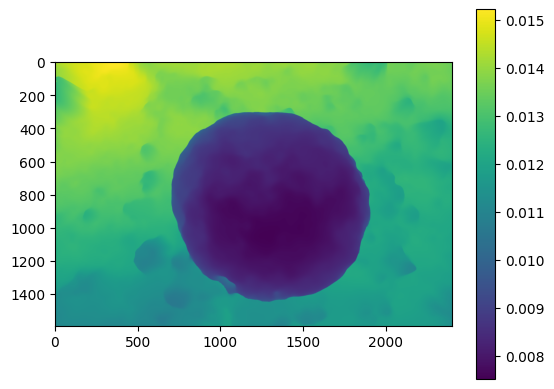

In [278]:
B_b = estimate_backscatter(b_args[0], b_args[1], b_args[2], b_args[3], tif_flat).reshape((height, width))

imshow(B_b)

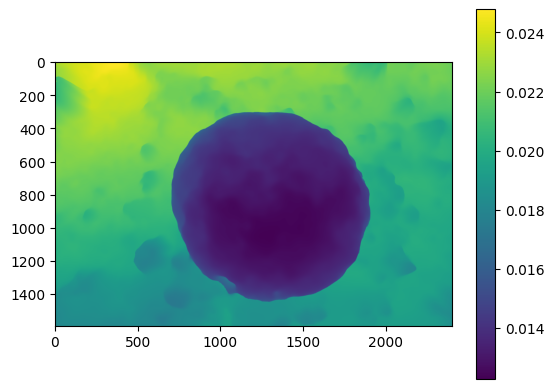

In [279]:
B_g = estimate_backscatter(g_args[0], g_args[1], g_args[2], g_args[3], tif_flat).reshape((height, width))

imshow(B_g)

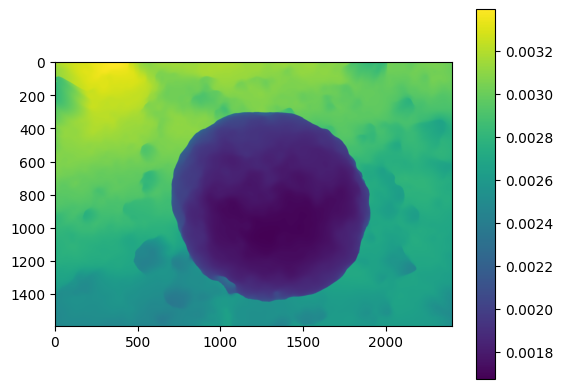

In [280]:
B_r = estimate_backscatter(r_args[0], r_args[1], r_args[2], r_args[3], tif_flat).reshape((height, width))

imshow(B_r)

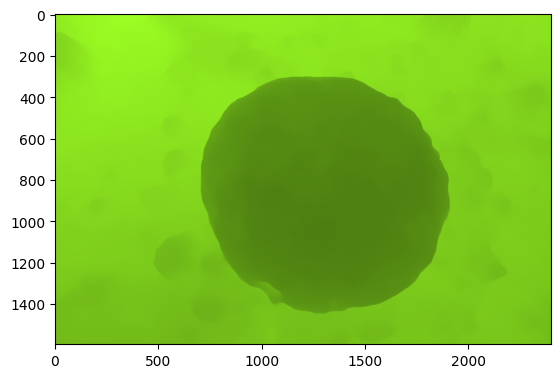

In [281]:
backscatter = np.zeros((height, width, 3), dtype=np.float64)

backscatter[:, :, 0] = B_b
backscatter[:, :, 1] = B_g
backscatter[:, :, 2] = B_r

imshow(backscatter / backscatter.max())

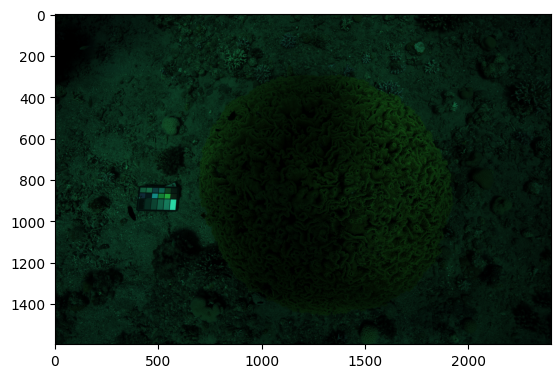

In [282]:
direct_signal = png - backscatter

# sig_min_b = direct_signal[:, :, 0].min()
# sig_min_g = direct_signal[:, :, 1].min()
# sig_min_r = direct_signal[:, :, 2].min()

# if sig_min_b > 0:
#     sig_min_b = 0

# if sig_min_g > 0:
#     sig_min_g = 0

# if sig_min_r > 0:
#     sig_min_r = 0

# direct_signal[:, :, 0] = direct_signal[:, :, 0] - sig_min_b
# direct_signal[:, :, 1] = direct_signal[:, :, 1] - sig_min_g
# direct_signal[:, :, 2] = direct_signal[:, :, 2] - sig_min_r

direct_signal = np.clip(direct_signal, 0, 1)

imshow(direct_signal, color_channel="bgr")

In [283]:
# plt.imshow((png < backscatter)[:, :, 0])

In [284]:
# np.savez_compressed(f"./output/DS_{name}.npz", direct_signal=direct_signal.astype(np.float32))

# direct_signal.shape

## Attenuation Coefficient Estimation

### Coarse Estimate of $\beta_c^D(z)$

In [285]:
epsilon_percent = 0.1
convergence_threshold = 0.001
f = 2.0
p = 0.1

In [286]:
epsilon = (tif.max() - tif_flat[tif_flat != 0].min()) * epsilon_percent

epsilon

np.float32(0.1065607)

In [287]:
def pad_tensor(tensor: torch.Tensor, top: int, right: int, left: int, bottom: int) -> torch.Tensor:
    dim = len(tensor.shape)

    if len(tensor.shape) == 2:
        tensor = tensor[:, :, None]

    height, width, channels = tensor.shape

    new_height = height + top + bottom
    new_width = width + right + left

    bottom_idx = new_height - bottom
    right_idx = new_width - right

    padded = torch.zeros((new_height, new_width, channels), device=device)
    padded[top:bottom_idx, left:right_idx, :] = tensor

    if dim == 2:
        return padded[:, :]
    else:
        return padded


In [288]:
def pad_direction(tensor: torch.Tensor):
    if len(tensor.shape) == 2:
        tensor = tensor[:, :, None]

    height, width, channels = tensor.shape

    direction = torch.zeros((height + 2, width + 2, 9, channels), device=device)
    direction[:, :, 0, :] = pad_tensor(tensor, 2, 1, 1, 0)
    direction[:, :, 1, :] = pad_tensor(tensor, 1, 2, 0, 1)
    direction[:, :, 2, :] = pad_tensor(tensor, 0, 1, 1, 2)
    direction[:, :, 3, :] = pad_tensor(tensor, 1, 0, 2, 1)
    
    direction[:, :, 4, :] = pad_tensor(tensor, 2, 2, 0, 0) #top: int, right: int, left: int, bottom: int
    direction[:, :, 5, :] = pad_tensor(tensor, 0, 2, 0, 2)
    direction[:, :, 6, :] = pad_tensor(tensor, 0, 0, 2, 2)
    direction[:, :, 7, :] = pad_tensor(tensor, 2, 0, 2, 0)

    direction[:, :, 8, :] = pad_tensor(tensor, 1, 1, 1, 1)

    return direction

In [289]:
direct_signal_tensor = pad_tensor(torch.as_tensor(direct_signal, device=device), 1, 1, 1, 1)
a_values_tensor = direct_signal_tensor
depths_tensor = torch.as_tensor(tif, device=device)
diff_depth_map_tensor = torch.abs(torch.dstack([pad_tensor(depths_tensor, 1, 1, 1, 1)] * 9) - pad_direction(depths_tensor).squeeze())
softmax = func.softmax(-diff_depth_map_tensor, dim=-1)
weights = torch.stack([softmax] * 3, dim=-1)

for i in range(1):
    print("hi")
    a_values_tensor = pad_direction(a_values_tensor[1:-1, 1:-1, :])
    a_values_tensor = torch.sum(weights * a_values_tensor, axis=2)
    a_values_tensor = (1 - p) * a_values_tensor + p * direct_signal_tensor

a_values_tensor.shape

hi


torch.Size([1598, 2402, 3])

In [290]:
a_values = a_values_tensor[1:-1, 1:-1, :].detach().cpu().numpy()

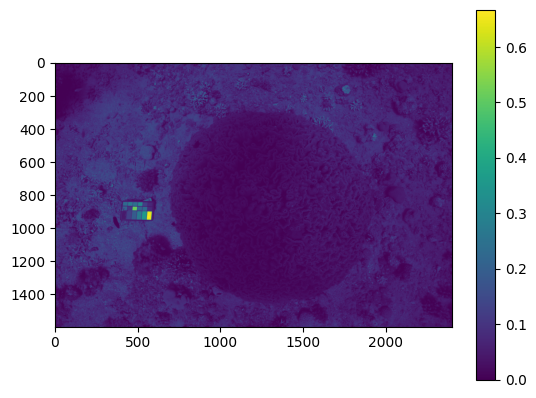

In [291]:
imshow(a_values[:, :, 0])

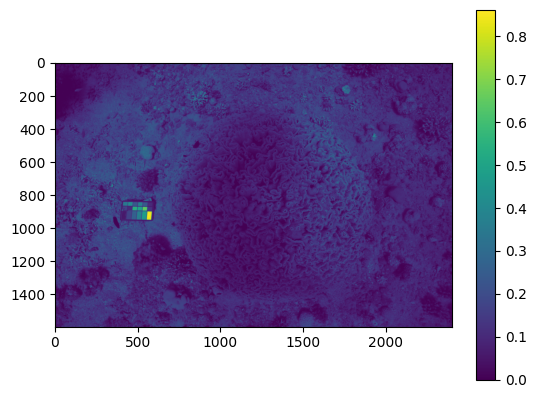

In [292]:
imshow(a_values[:, :, 1])

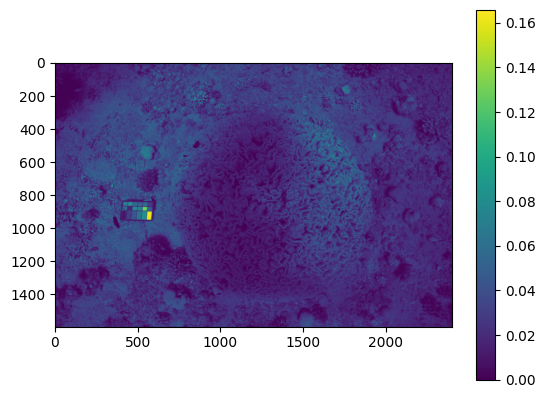

In [293]:
imshow(a_values[:, :, 2])

# Debug Cuda Implementation

## Original Implementation

1.7235601


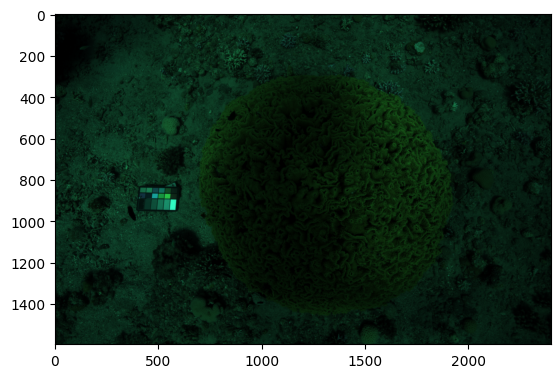

In [294]:
local_illuminant_map = f * a_values

print(local_illuminant_map.max())
imshow(local_illuminant_map / local_illuminant_map.max(), color_channel="bgr")

## Latest Implementation (Mostly Free From from Here)

In [295]:
local_illuminant_map, direct_signal, tif

local_illuminant_map.tofile("T_S04923_lim.bin")
direct_signal.tofile("T_S04923_ds.bin")
tif.tofile("T_S04923_depth.bin")

In [296]:
local_illuminant_map.shape

(1596, 2400, 3)

In [297]:
local_illuminant_map.dtype,direct_signal.dtype,tif.dtype

(dtype('float32'), dtype('float64'), dtype('float32'))

nan


C:\Users\seanh\AppData\Local\Temp\ipykernel_27128\239008167.py:5: RuntimeWarning: invalid value encountered in cast
  return (array * 255).astype(np.uint8)


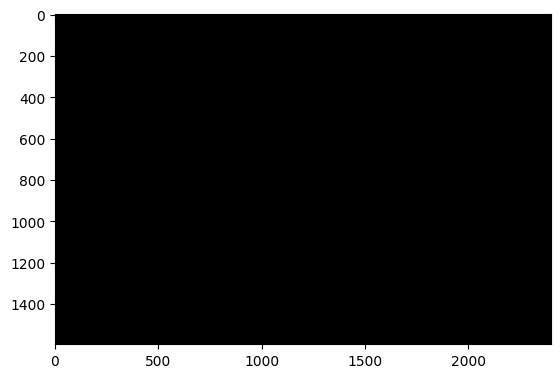

In [298]:
a_c_new = np.fromfile(f"data/{name}_a_c.bin")
a_c_new = a_c_new.reshape(direct_signal.shape)
local_illuminant_map = f * a_c_new

print(local_illuminant_map.max())
imshow(local_illuminant_map / local_illuminant_map.max(), color_channel="bgr")

C:\Users\seanh\AppData\Local\Temp\ipykernel_27128\239008167.py:5: RuntimeWarning: invalid value encountered in cast
  return (array * 255).astype(np.uint8)


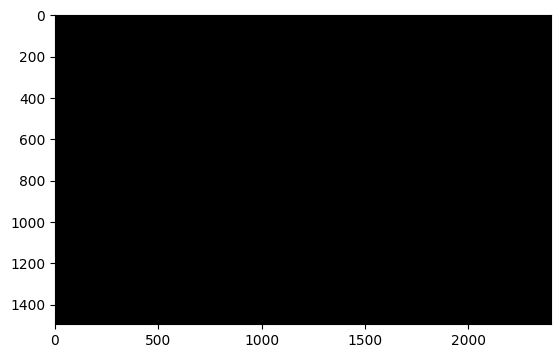

In [299]:
local_illuminant_map2 = f * a_c_new
local_illuminant_map1 = f * a_values

diff_lim = np.abs(local_illuminant_map1[:-100] - local_illuminant_map2[:-100])

imshow(diff_lim / diff_lim.max(), color_channel="bgr")

In [300]:
diff_lim.max()

np.float64(nan)

In [302]:
np.isnan(diff_lim).sum()/diff_lim.flatten().shape[0]

np.float64(0.0071189839572192515)